In [2]:
import numpy as np

In [3]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
import keras

In [4]:
from keras.layers import *
from keras import Model 

In [34]:
num_datasets = 4

In [35]:
from DatasetHandler.BiwiBrowser import *
biwi = readBIWIDataset(subjectList = [s for s in range(1, num_datasets+1)])#

Frames from /home/mcicek/Datasets/HeadPoses/biwi/hpdb/ have been started to read by 2018-12-21 01:34:28.426147
Subject 01's frames have been started to read 2018-12-21 01:34:28.427420
Subject 01's all frames have been read by 2018-12-21 01:34:28.427454
Subject 02's frames have been started to read 2018-12-21 01:34:28.428568
Subject 02's all frames have been read by 2018-12-21 01:34:28.428592
Subject 03's frames have been started to read 2018-12-21 01:34:28.429708
Subject 03's all frames have been read by 2018-12-21 01:34:28.429726
Subject 04's frames have been started to read 2018-12-21 01:34:28.430863
Subject 04's all frames have been read by 2018-12-21 01:34:28.430880
/home/mcicek/Datasets/HeadPoses/biwi/db_annotations.tgz has been started to read by 2018-12-21 01:34:28.430890
4 annotations have been read by 2018-12-21 01:34:30.450402


In [6]:
num_outputs = 1

In [84]:
keras.backend.clear_session()
def getFinalModel(num_outputs = num_outputs):
    dense_layer_1 = 1#int((patch_size[0] * patch_size[1]) / 1)0010#00000
    dense_layer_2 = 8
    
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape = BIWI_Frame_Shape)
    block5_pool = vgg16.get_layer('block5_pool').output
    gate = (int(d) for d in block5_pool.shape[1:])
    #vgg16.summary()
    # This shape has to match the last layer in VGG16 (without top)
    dense_input  = Input(shape=gate) #patch_size) #(15, 20, 512)
    print(dense_input.shape)
    dense_output = Flatten(name='flat')(dense_input)
    print(dense_output.shape)
    #dense_output = Reshape((?, 10, ?), name='per')(dense_input)
    print(dense_output.shape)
   # dense_output = Dense(dense_layer_2, activation='relu', name='fc2')(dense_output)
    dense_output = LSTM(dense_layer_1, activation='relu', name='lstm1',return_sequences=True)(dense_output)
    dense_output = Dense(num_outputs, name='predictions')(dense_output)

    top_model = Model(inputs=dense_input, outputs=dense_output, name='top_model')
    # Now combine the two models
    full_output = top_model(block5_pool)
    full_model  = Model(inputs=vgg16.input, outputs=full_output)

    for layer in full_model.layers[:15]:
        layer.trainable = False
    full_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])#'accuracy'
    return full_model

In [85]:
full_model = getFinalModel(num_outputs = num_outputs)

(?, 15, 20, 512)
(?, ?)
(?, ?)


ValueError: Input 0 is incompatible with layer lstm1: expected ndim=3, found ndim=2

In [38]:
c = 0
frames, labelsList = [], []
for inputMatrix, labels in biwi:
    if c < num_datasets-1:
        full_model.fit(inputMatrix, labels[:, :num_outputs], batch_size=10, epochs=1, verbose=2)
    else:
        frames.append(inputMatrix)
        labelsList.append(labels)
    c += 1

Epoch 1/1
 - 15s - loss: 2207.3987 - mean_absolute_error: 33.2167
Epoch 1/1
 - 15s - loss: 2630.5205 - mean_absolute_error: 28.6559
Epoch 1/1
 - 22s - loss: 108.5136 - mean_absolute_error: 7.5625


In [39]:
test_inputMatrix, test_labels = frames[0], labelsList[0]

In [40]:
predictions = full_model.predict(test_inputMatrix, batch_size=10)

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
output1 = numpy.concatenate((test_labels[:, :1], predictions[:, :1]), axis=1)

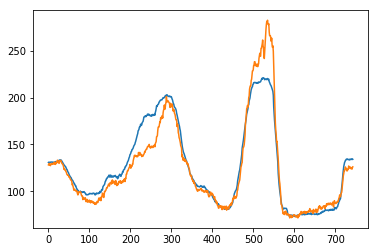

In [43]:
plt.plot(output1)

In [ ]:
output1 = numpy.concatenate((test_labels[:, :1], predictions[:, :1]), axis=1)
output2 = numpy.concatenate((test_labels[:, 1:2], predictions[:, 1:2]), axis=1)
output3 = numpy.concatenate((test_labels[:, 2:3], predictions[:, 2:3]), axis=1)

In [ ]:
# Three subplots sharing both x/y axes
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
ax1.plot(output1)
ax1.set_title('Sharing both axes')
ax2.plot(output2)
ax3.plot(output3)
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)